<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint13/M4_DS_414_Topic_Modeling_Lecture_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)


![](https://drive.google.com/uc?export=view&id=1Aze8Xe_ZZpV22IwFNUH09T2howHmF1AK)

[Image Credit: slides from Ben Mabey](https://speakerdeck.com/bmabey/visualizing-topic-models)

In Module 1, we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are often not explicitly called out and labeled in the document corpus. So some extra work is needed to figure out the topics. Today we will learn a powerful technique for doing this (almost) automatically!

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: What the are your documents about? <br>
What are some industrial applications?
* Identifying common themes in customer reviews
* Grouping job ads into categories
* Sorting customer inquiries into categories so they can be routed to the appropriate department for processing.
* Monitoring communications (Email - State Department, Google)

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 1: Describe how a Latent Dirichlet Allocation (LDA) Model works
* Part 2: Build a LDA Model with Gensim
* Part 3: Interpret LDA results & Select an appropriate number of topics

##1.0 Setup

##1.0.1 Get spacy

In [3]:
# could use *web_lg or *web_sm instead
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 18.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 1.0.1 Restart runtime!
On Colab, we need to restart runtime after this step, <br>
or else Colab won't find spacy!

##1.0.2 Install dependencies

In [1]:
# Dependencies for the week (instead of conda)
# Run if you're using colab, otherwise you should have a local copy of the data
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
!pip install -r requirements.txt

--2024-05-14 00:56:18--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132 [text/plain]
Saving to: ‘requirements.txt.1’

requirements.txt.1  100%[===================>]     132  --.-KB/s    in 0s      

2024-05-14 00:56:18 (4.22 MB/s) - ‘requirements.txt.1’ saved [132/132]



##1.0.3 Imports and such

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.datasets import fetch_20newsgroups
from pandarallel import pandarallel

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Part 1: Building a Latent Dirichlet Allocation (LDA) Topic Model with Gensim

Our goal in this module is to get hands-on experience in how to build and train a Latent Dirichlet Allocation topic model using the **Gensim** library.

## 1.1 Latent Dirichlet Allocation (LDA)
is a more sophisticated method of topic modelling than Latent Semantic Indexing (LSI) which we used in Module 2. Because of its complexity, a full discussion of the machinery of LDA is beyond the scope of Unit 4. We'll focus on a high level of understanding of Latent Dirichlet Allocation, meaning we'll emphasize "what it does" rather than "how it does it".

LDA takes as input the corpora of documents and the number of topics that you want to identify. LDA models topics as probability distributions over words, and it models documents as probability distributions over topics.

LDA is a generative probabilistic model. That means it can generate documents from probability distributions. Given an article length (number of words), an assumed probability distribution of topics, and an assumed distribution of words for each topic, LDA can generate an article, in the form of a bag of words. LDA works by starting with random distributions of words over topics and  topics over documents, then iteratively adjust these probability distributions until the generated documents are similar in structure to the input documents.





### 1.1.1 Resources for LDA

[**Your Guide to Latent Dirichlet Allocation**](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d) is a highly recommended Medium article that works through an example of LDA in elementary terms

[**LDA Topic Modeling**](https://lettier.com/projects/lda-topic-modeling/) is an interactive data visualization tool -- created by the author of the above article -- that allows us to explore a simple and visual example of LDA.

[**Topic Modeling with Gensim**](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) disccusses an example implementing LDA using the same dataset that we are using in this guided project.  

Luis Serrano's video [**Latent Dirichlet Allocation**](https://youtu.be/T05t-SqKArY) does a great job of breaking down and explaining LDA in an understandable way.



### 1.1.2 Further discussion of LDA (Optional)

LDA is a [**Probabilistic Graphical Model (PGM)**](https://en.wikipedia.org/wiki/Graphical_model)

A PGM can be represented by a graph that expresses the conditional dependence structure between random variables. Here's a graphical representation of the LDA model:

![](https://filebox.ece.vt.edu/~s14ece6504/projects/alfadda_topic/main_figure_3.png)

The image shows the hierarchical dependency between probability distributions and their parameters. This is an application of Hierarchical Bayesian Modeling.

In order to understand how LDA works, one must first understand how PGMs work, which is beyond the scope of Unit 4. If this is something that you're interested in learning more about, here are some resources:

This Github repo that has transformed a textbook in a collection of Jupyter Notebooks. This repo is called [**"Bayesian Methods for Hackers"**](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) <br>
The cool thing about this repo is that each chapter covers the same material using four popular python probabilistic modeling libraries: **PyMC2, PyMC3, Pyro, and Tensorflow Probability.** So you can choose your preferred library.

[**Pyro**](https://pyro.ai/) is considered a very powerful probabilistic programming library that even combines probabilistic programming with deep learning.

## 1.2 Preparing our text data set for LDA topic modeling with `gensim`
For this guided project we'll work with the `20newsgroups` data set that is  familiar from Module 3, but we'll extract articles from a different set of categories.<br><br>
`gensim` is a Natural Language Processing Library, specialized for Topic Modeling applications. The two main inputs required for a `gensim` LDA topic model are the dictionary (`id2word`) and the `corpus`.<br><br>
`id2word` is a special object created by `gensim` that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text <br><br>
The `corpus` is a specially formatted list containing information about each document. Though its format is different, is essentially equivalent to the document-term matrix that we used with `sklearn`.<br>

In this section, we will first download and clean the raw text documents, then use `spacy` to tokenize and lemmatize them. Then we'll use `gensim` to create the `id2word` and `corpus` objects that we need for topic modeling with `gensim`<br>

In Part 2, we'll build and train the LDA topic model in `gensim`.

References:
- [Gensim Tutorial – A Complete Beginners Guide](https://www.machinelearningplus.com/nlp/gensim-tutorial/)
- [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

# Problem Statement



We'll extract articles belonging to the following four topics (as assigned in the 20newsgroups database)

    sci
        \_ electronics, space


    talk
        \_politics
                  \_ guns, middle east
              
What's the best way to categorize these emails - is it between science and talk?

Or it between electronics, space, guns, and the Middle East?

The Middle East is a pretty broad topic in and of itself, should that topic be broken down into further sub-topics?

Let's learn about Topic Modeling and how it can help us answer these questions!

### Load Email Corpus


In [3]:
# notice that the categories are hierarchical
# so there is a sense in which we have 2 topics, but also as many as 4 topics
categories = ['sci.electronics', 'sci.space',
              'talk.politics.guns', 'talk.politics.mideast']
data = fetch_20newsgroups(subset='all',
                          remove=('headers', 'footers', 'quotes'),
                          random_state=42, shuffle=True,
                          categories=categories)

In [4]:
dir(data)

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [5]:
# create X and y from data, as we did in the Module 3 Lecture notebook
###BEGIN SOLUTION
X = data.data
y = data.target # numerical label for each category
target_names = data.target_names

What are the possible targets (labels)

In [6]:
np.unique(y)

array([0, 1, 2, 3])

What are the newsgroup names that correspond to the labels?

In [7]:
target_names

['sci.electronics', 'sci.space', 'talk.politics.guns', 'talk.politics.mideast']

Create a data frame with columns for the documents, the newsgroup names, and their numerical labels.

In [8]:
data_dict = {
    'content': X,
    'target': y,
    'target_names': [target_names[target_index] for target_index in y]
}

df = pd.DataFrame(data=data_dict)
print(df.shape)
df.head()

(3821, 3)


,content,target,target_names
0,[...]\n\nSome of the Davidians *are* black.\...,2,talk.politics.guns
1,"\n\n How about ""firearm related.""\n\n\n ...",2,talk.politics.guns
2,==========================\n ...,1,sci.space
3,"From: ""Phil G. Fraering"" <pgf@srl03.cacs.usl.e...",1,sci.space
4,"From article <93859@hydra.gatech.EDU>, by gs26...",2,talk.politics.guns


Re-use our `clean_data()` helper function from Module 3.

In [14]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document.

    Parameters
    ----------
    text: string or object

    Returns
    -------
    text: string or object
    """

    # order of operations - apply the expression from top to bottom
    email_regex = "From: \S*@\S*\s?" # remove any emails
    non_alpha = '[^a-zA-Z]' # remove non alpha characters
    multi_white_spaces = "[ ]{2,}" # replace multiple spaces with single space

    text = re.sub(email_regex, "", text)
    text = re.sub(non_alpha, ' ', text)
    text = re.sub(multi_white_spaces, " ", text)

    # apply case normalization
    return text.lower().lstrip().rstrip() # remove white space left and right to text

Clean the text string data and save it in a new column

In [15]:
df["clean_data"] = df["content"].apply(clean_data)
df.head()

,content,target,target_names,clean_data
0,[...]\n\nSome of the Davidians *are* black.\...,2,talk.politics.guns,some of the davidians are black next question
1,"\n\n How about ""firearm related.""\n\n\n ...",2,talk.politics.guns,how about firearm related texas is unusual in ...
2,==========================\n ...,1,sci.space,ozone gif images april two gif images of the o...
3,"From: ""Phil G. Fraering"" <pgf@srl03.cacs.usl.e...",1,sci.space,from phil g fraering pgf srl cacs usl edu fina...
4,"From article <93859@hydra.gatech.EDU>, by gs26...",2,talk.politics.guns,from article hydra gatech edu by gs prism gate...


### Create Tokens

Before we can use the `gensim` library to create bag-of-words vectors in exactly the right way that the LDA model wants, we must first create tokens.

Let's use spaCy to create some lemmas. But first let's initialize our multi-processing library `pandarallel` which will empower us to use the same dataframe that our data is stored in but be able to create tokens in parallel so as to save time.

Here's the documentation for [**pandarallel**](https://github.com/nalepae/pandarallel)

In [16]:
# we must initalize pandarallel before we can use it
# To parallelize operations
pandarallel.initialize(progress_bar=True, nb_workers=10)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [17]:
# load in our spaCy language model
nlp = spacy.load("en_core_web_md", disable=['tagger', 'parser'])

In [18]:
%%time
# create our tokens in the form of lemmas

# If you're on macOS, Linux, or python session executed from Windows Subsystem for Linux (WSL)
# conda activate U4-S1-NLP
# pip install pandarallel
#
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)
#
# Ref: https://github.com/nalepae/pandarallel
#
# If running on local Windows machine, uncomment the 3 lines below
# from tqdm import tqdm
# tqdm.pandas()
#
# df['lemmas'] = df['content'].progress_apply(get_lemmas)

# Parallel_map takes about 20 sec
# grab lemmas, strip white spaces, tokenize with spacy, remove stop words, remove punctuations - all the tasks distributed among 10 workers or 10 nodes on our CPU
df['lemmas'] = df['clean_data'].parallel_map(lambda x: [token.lemma_.strip() for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])

CPU times: user 1.13 s, sys: 421 ms, total: 1.55 s
Wall time: 1min 50s


### Take a look at our lemmas

In [19]:
df['clean_data'][5]

'from gene wright gene theporch raider net i ll say imagine that there were a couple groups up there maybe landing a few weeks apart the year mark starts coming on for the first group isn t a billion pretty good incentive to take a shot at a potential winner yeah that s a shame that team a s life support gave out so close to the deadline thanks for the billion on the other hand if apollo cost billion for a few days or weeks in space in dollars then won t the reward have to be a lot more than only billion to get any takers tommy mac tom mcwilliams wk as the radius of vision increases tm ibm cl msu edu hm the circumference of mystery grows'

In [20]:
# print out the lemmas from the first article
# note that some lemmas are only 1 character: you could modify the code above to not include lemmas that are only 1 or 2 characters
df['lemmas'][5]

['gene',
 'wright',
 'gene',
 'theporch',
 'raider',
 'net',
 'll',
 'imagine',
 'couple',
 'groups',
 'maybe',
 'landing',
 'weeks',
 'apart',
 'year',
 'mark',
 'starts',
 'coming',
 'group',
 'isn',
 't',
 'billion',
 'pretty',
 'good',
 'incentive',
 'shot',
 'potential',
 'winner',
 'yeah',
 's',
 'shame',
 'team',
 's',
 'life',
 'support',
 'gave',
 'close',
 'deadline',
 'thanks',
 'billion',
 'hand',
 'apollo',
 'cost',
 'billion',
 'days',
 'weeks',
 'space',
 'dollars',
 'won',
 't',
 'reward',
 'lot',
 'billion',
 'takers',
 'tommy',
 'mac',
 'tom',
 'mcwilliams',
 'wk',
 'radius',
 'vision',
 'increases',
 'tm',
 'ibm',
 'cl',
 'msu',
 'edu',
 'hm',
 'circumference',
 'mystery',
 'grows']

### Filter out low quality lemmas
1 or 2 characters

In [21]:
def filter_lemmas(lemmas):
    """
    Filter out any lemmas that are 2 characters or smaller
    """
    return [lemma for lemma in lemmas if len(lemma) > 2]

In [22]:
# apply filter_lemmas
df["filtered_lemmas"] = df["lemmas"].parallel_map(filter_lemmas)

In [23]:
df["filtered_lemmas"][5]

['gene',
 'wright',
 'gene',
 'theporch',
 'raider',
 'net',
 'imagine',
 'couple',
 'groups',
 'maybe',
 'landing',
 'weeks',
 'apart',
 'year',
 'mark',
 'starts',
 'coming',
 'group',
 'isn',
 'billion',
 'pretty',
 'good',
 'incentive',
 'shot',
 'potential',
 'winner',
 'yeah',
 'shame',
 'team',
 'life',
 'support',
 'gave',
 'close',
 'deadline',
 'thanks',
 'billion',
 'hand',
 'apollo',
 'cost',
 'billion',
 'days',
 'weeks',
 'space',
 'dollars',
 'won',
 'reward',
 'lot',
 'billion',
 'takers',
 'tommy',
 'mac',
 'tom',
 'mcwilliams',
 'radius',
 'vision',
 'increases',
 'ibm',
 'msu',
 'edu',
 'circumference',
 'mystery',
 'grows']

### The two main inputs to the `gensim` LDA topic model are the dictionary (`id2word`) and the `corpus`.
- `id2word` is a special object created by `gensim` that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text <br>
- The `corpus` is a specially formatted list containing information about each document. Though its format is different, is essentially equivalent to the document-term matrix that we used with `sklearn`

### Create the `id2word` dictionary

In [24]:
# 1. Create Dictionary

# 2. Term Document Frequency is (token id, token count) for each doc in the corpus

# 3. Human readable format of corpus (term-frequency)

### BEGIN SOLUTION
# from gensim, from corpora module
# 1. Create Dictionary from the corpus
id2word = corpora.Dictionary(df['filtered_lemmas'])

In [25]:
# How many words do we have in our vocabulary?
len(id2word.keys())

33988

In [26]:
# Let's remove extreme values from the dataset
# no_below removes any word that appears in fewer specified number of documents
id2word.filter_extremes(no_below=3, no_above=0.5) # no_below=3 means removing word only appears in max 2 docs, and no_above=100 means removing word appears in more than 100 docs, 0.5 means more than 50%
# additional stop word removal beyond our stop word list


In [27]:
# Now how many words do we have in our vocabulary dictionary?
len(id2word.keys())

12995

Use the `id2word.doc2bow()` method to process a first document into a list of word counts

In [28]:
df['clean_data'].iloc[5]

'from gene wright gene theporch raider net i ll say imagine that there were a couple groups up there maybe landing a few weeks apart the year mark starts coming on for the first group isn t a billion pretty good incentive to take a shot at a potential winner yeah that s a shame that team a s life support gave out so close to the deadline thanks for the billion on the other hand if apollo cost billion for a few days or weeks in space in dollars then won t the reward have to be a lot more than only billion to get any takers tommy mac tom mcwilliams wk as the radius of vision increases tm ibm cl msu edu hm the circumference of mystery grows'

In [29]:
id2word.doc2bow(df['filtered_lemmas'][5])
# word 29 appears 1 time, word 35 appears 1 time, etc.

[(29, 1),
 (35, 1),
 (103, 1),
 (175, 1),
 (179, 1),
 (197, 1),
 (199, 1),
 (206, 1),
 (209, 1),
 (210, 1),
 (213, 1),
 (214, 1),
 (216, 1),
 (217, 1),
 (226, 1),
 (235, 1),
 (236, 1),
 (241, 1),
 (259, 1),
 (260, 1),
 (261, 4),
 (262, 1),
 (263, 1),
 (264, 1),
 (265, 1),
 (266, 1),
 (267, 1),
 (268, 2),
 (269, 1),
 (270, 1),
 (271, 1),
 (272, 1),
 (273, 1),
 (274, 1),
 (275, 1),
 (276, 1),
 (277, 1),
 (278, 1),
 (279, 1),
 (280, 1),
 (281, 1),
 (282, 1),
 (283, 1),
 (284, 1),
 (285, 1),
 (286, 1),
 (287, 1),
 (288, 2),
 (289, 1),
 (290, 1),
 (291, 1),
 (292, 1),
 (293, 1)]

### Create the `corpus`
by processing all the documents using a list comprehension

In [30]:
# 2. Term Document Frequency

# We want a list of (token id, token count) for each doc in the corpus
# So we apply exactly what we did to each doc

# Term Document Frequency -- different format, but equivalent in function to the document-term matrix we used in sklearn
corpus = [id2word.doc2bow(doc_lemmas) for doc_lemmas in df['filtered_lemmas']]

# Check the data type and length of corpus
print(type(corpus))
print(len(corpus))

<class 'list'>
3821


In [31]:

### BEGIN SOLUTION

# 3. Human readable format of corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[5]] # corpus[5] is the 5th document in the corpus, look up the word_id in our dictionary, return in tuple

### END SOLUTION
# word appearance and its frequency

[('group', 1),
 ('isn', 1),
 ('days', 1),
 ('space', 1),
 ('team', 1),
 ('circumference', 1),
 ('edu', 1),
 ('grows', 1),
 ('ibm', 1),
 ('increases', 1),
 ('mac', 1),
 ('mcwilliams', 1),
 ('msu', 1),
 ('mystery', 1),
 ('radius', 1),
 ('tom', 1),
 ('tommy', 1),
 ('vision', 1),
 ('apart', 1),
 ('apollo', 1),
 ('billion', 4),
 ('close', 1),
 ('coming', 1),
 ('cost', 1),
 ('couple', 1),
 ('dollars', 1),
 ('gave', 1),
 ('gene', 2),
 ('good', 1),
 ('groups', 1),
 ('hand', 1),
 ('imagine', 1),
 ('incentive', 1),
 ('landing', 1),
 ('life', 1),
 ('lot', 1),
 ('mark', 1),
 ('maybe', 1),
 ('net', 1),
 ('potential', 1),
 ('pretty', 1),
 ('reward', 1),
 ('shame', 1),
 ('shot', 1),
 ('starts', 1),
 ('support', 1),
 ('thanks', 1),
 ('weeks', 2),
 ('winner', 1),
 ('won', 1),
 ('wright', 1),
 ('yeah', 1),
 ('year', 1)]

# Part 2: Estimate a Latent Dirichlet Allocation (LDA) Model with `gensim`

 ### Train an LDA model

In [ ]:
### This cell runs the single-processor version of the model (slower)
# %%time
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20,
#                                            chunksize=100,
#                                            passes=10,
#                                            per_word_topics=True)
# lda_model.save('lda_model.model')
# # https://radimrehurek.com/gensim/models/ldamodel.html

#### The multi-processor version of gensim's LDA model is `gensim.models.ldamulticore.LdaMulticore()`, <br> which runs faster than the single-core version `gensim.models.ldamodel.LdaModel()`


In [32]:
%%time
from gensim.models.ldamulticore import LdaMulticore
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_topics = 2
lda_multicore_2_topics = LdaMulticore(corpus=corpus,          # Required input
                                      id2word=id2word,        # Required
                                      num_topics=num_topics,  # Required
                                      chunksize=250,          # How many docs are being looked at at a time, before updating the weights
                                      passes=20,              # Runtime related parameter, similar to an epoch, iterate over 20 times
                                      per_word_topics=True,
                                      workers=10,             # Set based on your machine capability
                                      random_state=42)
# Results: The lower the perplexity the better

CPU times: user 9.75 s, sys: 631 ms, total: 10.4 s
Wall time: 49.6 s


In [34]:
num_topics = 6
lda_multicore_6_topics = LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      chunksize=250,
                                      passes=20,
                                      per_word_topics=True,
                                      workers=10,
                                      random_state=42)

# Part 3: Interpret LDA results & Select the appropriate number of topics
LDAvis provides an interactive visualization of the topics estimated using Latent Dirichlet Allocation (LDA).<br>
We will use the `pyLDAvis` library which implements [LDAvis](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) in `python`.<br>


### 3.1 Visualizing the topics in our models

In [33]:
# For the 2-topic model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_2_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.119735  0.0       1        1  59.299899
0     -0.119735  0.0       2        1  40.700101, topic_info=       Term         Freq        Total Category  logprob  loglift
175   space  1321.000000  1321.000000  Default  30.0000  30.0000
580  israel   807.000000   807.000000  Default  29.0000  29.0000
145    nasa   440.000000   440.000000  Default  28.0000  28.0000
668    data   429.000000   429.000000  Default  27.0000  27.0000
50   people  2043.000000  2043.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
18      don   425.928723  1436.273696   Topic2  -5.8020  -0.3166
330     etc   250.515144   359.980029   Topic2  -6.3328   0.5364
186   years   280.323083   633.148325   Topic2  -6.2204   0.0842
73    think   299.069427   969.729700   Topic2  -6.1556  -0.2774
640    want   242.670684   630.939292   Topic2  -6.3646  -0.0566

[163 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
8406      1  0.995006     ankara
8406      2  0.008223     ankara
2073      1  0.012081    antenna
2073      2  0.990664    antenna
6919      1  0.994767  apartment
...     ...       ...        ...
1911      2  0.032801      women
553       1  0.382730       work
553       2  0.617777       work
186       1  0.557531      years
186       2  0.442234      years

[250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [35]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_6_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.114810  0.040835       1        1  26.507396
4      0.205164 -0.060943       2        1  25.572264
3     -0.024398 -0.059129       3        1  18.162106
1     -0.058849  0.211904       4        1  11.431741
5     -0.147313 -0.120562       5        1  10.768361
0     -0.089414 -0.012105       6        1   7.558131, topic_info=           Term         Freq        Total Category  logprob  loglift
175       space  1382.000000  1382.000000  Default  30.0000  30.0000
580      israel   826.000000   826.000000  Default  29.0000  29.0000
793    armenian   983.000000   983.000000  Default  28.0000  28.0000
794   armenians   808.000000   808.000000  Default  27.0000  27.0000
1883    turkish   593.000000   593.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
476       state    64.719643   558.138120   Topic6  -6.0026   0.4280
293        year    62.932743   483.999039   Topic6  -6.0306   0.5425
1883    turkish    63.037542   593.779387   Topic6  -6.0290   0.3398
18          don    66.387402  1436.067706   Topic6  -5.9772  -0.4916
186       years    63.256296   630.827665   Topic6  -6.0255   0.2827

[449 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
516        1  0.559263  actually
516        2  0.200985  actually
516        3  0.157293  actually
516        4  0.008738  actually
516        5  0.017477  actually
...      ...       ...       ...
10995      6  0.931755      zinc
2398       3  0.976106   zionism
2399       3  0.959952   zionist
2399       6  0.029999   zionist
9702       5  0.968032      zuma

[1094 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 2, 6, 1])

###3.2 What is topic coherence?


_Topic Coherence measures score a single topic by
measuring the degree of semantic similarity between
high scoring words in the topic._ <br>
-- From "Exploring Topic Coherence over many models and many topics", by Keith Stevens, Philip Kegelmeyer, David Andrzejewski, and David Buttler, Proceedings of the 2012 Joint Conference on Empirical Methods in Natural Language Processing and Computational Natural
Language Learning, pages 952–961, Jeju Island, Korea, 12–14 July 2012.
c 2012 Association for Computational Linguistics

_A set of statements or facts is said to be coherent, if they
support each other. Thus, a coherent fact set can be interpreted
in a context that covers all or most of the facts. An
example of a coherent fact set is 'the game is a team sport',
'the game is played with a ball', and 'the game demands great
physical e
fforts'_ -- from "Exploring the Space of Topic Coherence Measures", by Michael Roder, Andreas Both and Alexander Hinneburg https://dl.acm.org/doi/10.1145/2684822.2685324

We expect that documents in a topic category should be coherent, i.e., they should relate to each other. The same is true for words within a topic.


### Let's tune the "number of topics" hyperparameter
and choose the model with the best Topic Coherence score.

Higher coherence means there are more words unique to that topic.

In [37]:
def compute_coherence_values(dictionary, corpus, texts, limit=None, start=None, step=None):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics,
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v') # c_v is the most common coherence metric, look at all the top words in each topic and see how much overlap
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [38]:
%%time
# takes about 3 min
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['filtered_lemmas'], start=2, limit=10, step=1)
# Starting on 2 topics, going out to 10 with a 1 topic increment, but if there are a lot, might need to increase the step size

CPU times: user 1min 9s, sys: 3.67 s, total: 1min 13s
Wall time: 4min 21s


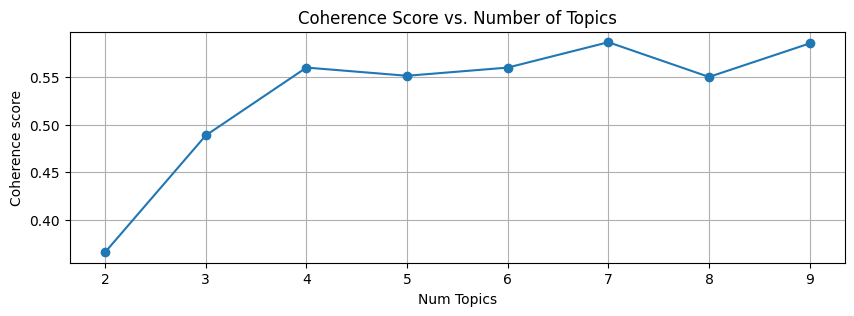

In [42]:
start=2; limit=10;  step=1;
x = range(start, limit, step)

plt.figure(figsize=(10,3))
plt.grid()
plt.plot(x, coherence_values, "-o")
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show();

Coherence score
- < 0.5 difficult topic model to do anything with
- < 0.5 improve the text or topic model
- 0.5-0.8 is considered very good,
- Larger than 0.8 questionable

### Select the "best" model as the one with the highest Topic Coherence Score

Due to the probabilistic nature of this model, the modeling results can and usually do vary. Despite this, we will select 8 as the number of topics even if this particular model run doesn't show 8 as having the highest coherence score. Also, even if it doesn't, we  need to ask ourselves how many topics we actually want for our corpus.

In [43]:
lda_trained_model = model_list[4]

In [44]:
lda_trained_model

### For each topic discovered by `gensim`, list the top ten words and their probabilities,

In [45]:
pprint(lda_trained_model.print_topics())

[(0,
  '0.011*"said" + 0.011*"people" + 0.007*"israel" + 0.006*"know" + '
  '0.005*"armenians" + 0.005*"don" + 0.005*"armenian" + 0.005*"israeli" + '
  '0.005*"didn" + 0.004*"like"'),
 (1,
  '0.013*"edu" + 0.011*"file" + 0.007*"space" + 0.006*"information" + '
  '0.006*"istanbul" + 0.005*"nasa" + 0.005*"available" + 0.005*"ftp" + '
  '0.005*"new" + 0.005*"university"'),
 (2,
  '0.010*"armenian" + 0.009*"turkish" + 0.008*"jews" + 0.007*"armenians" + '
  '0.006*"people" + 0.005*"jewish" + 0.005*"genocide" + 0.005*"government" + '
  '0.005*"war" + 0.004*"israel"'),
 (3,
  '0.009*"use" + 0.007*"like" + 0.006*"don" + 0.006*"know" + 0.005*"power" + '
  '0.005*"need" + 0.004*"good" + 0.004*"want" + 0.004*"ground" + '
  '0.004*"circuit"'),
 (4,
  '0.018*"space" + 0.006*"launch" + 0.005*"earth" + 0.005*"nasa" + '
  '0.004*"system" + 0.004*"orbit" + 0.004*"shuttle" + 0.004*"solar" + '
  '0.004*"moon" + 0.004*"mission"'),
 (5,
  '0.009*"people" + 0.009*"gun" + 0.008*"don" + 0.007*"think" + 0.006*

###Visualize the topics in the best model

In [46]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_trained_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.051340 -0.072221       1        1  23.828981
0     -0.175934 -0.031277       2        1  19.294111
2     -0.145136  0.117419       3        1  18.986726
4      0.119491 -0.032020       4        1  18.621097
3      0.100287 -0.169930       5        1  13.235821
1      0.152631  0.188029       6        1   6.033264, topic_info=          Term         Freq        Total Category  logprob  loglift
175      space  1360.000000  1360.000000  Default  30.0000  30.0000
793   armenian  1044.000000  1044.000000  Default  29.0000  29.0000
199        edu   489.000000   489.000000  Default  28.0000  28.0000
592        gun   795.000000   795.000000  Default  27.0000  27.0000
420       jews   635.000000   635.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1204       new    98.577267   718.853455   Topic6  -5.3565   0.8211
668       data    76.027695   423.137049   Topic6  -5.6163   1.0913
2964      mail    63.086071   194.256674   Topic6  -5.8029   1.6832
314       send    60.114463   194.954626   Topic6  -5.8511   1.6314
146       news    59.482659   300.216739   Topic6  -5.8617   1.1891

[454 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6207      2  0.030292         abu
6207      3  0.969351         abu
1258      1  0.978825   accidents
9512      3  0.989500         adl
4479      2  0.983636       agdam
...     ...       ...         ...
186       5  0.059979       years
186       6  0.006314       years
3497      2  0.018044  yugoslavia
3497      3  0.974377  yugoslavia
9702      3  0.984505        zuma

[1194 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 5, 4, 2])

## Create a Topic Id --> Topic Name dictionary


*****This is the "human intervention" step*****:<br>
Assign names to the topics based on what I know.
Edit `vis_topic_name_dict` with YOUR OWN names that YOU assign to the topics that `gensim` discovered.

When populating your Topic Id --> Topic Name dictionary, use the index ordering as shown in the `pyLDAvis` tool.

In [58]:
# keys - use topic ids from pyLDAvis visualization
# values - topic names that you create
# save dictionary to `vis_topic_name_dict`
###BEGIN SOLUTION
# this is the results from a model run however these topic names might not make sense in future model runs
# thus these names will likely have to be thought through during each lecture
vis_topic_name_dict = {1: 'politics on guns',
                       2: 'war',
                       3: 'politics in middle east',
                       4: 'space program',
                       5: 'electronics / power',
                       6: 'office'}
###END SOLUTION

## Create a Topic Id lookup dictionary
We'll use a function to map the `pyLDAvis` index ordering to the ordering used in gensim's trained LDA model.

In [59]:
# Mapping between visualization and our topic model
model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()
model_vis_tool_topic_id_lookup

{5: 1, 0: 2, 2: 3, 4: 4, 3: 5, 1: 6}

In [60]:
# To go back and forth
topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
topic_id_lookup

{1: 5, 2: 0, 3: 2, 4: 4, 5: 3, 6: 1}

In [61]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    Both the starting index and the ordering of topic ids bewteen the trained LDA model
    and the viz tool are different. So we need to create a look up dictionary that maps
    the correct association between topic ids from both sources.
    """
    # value is order of topic ids according to pyLDAvis tool
    # key is order of topic ids according to lda model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()

    # invert dictionary so that
    # key is order of topic ids accoridng to pyLDAvis tool
    # value is order of topic ids according to the trained lda model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}

    # iterate through topic_id_lookup and index vis_topic_name_dict using the keys
    # in order to swap the viz topic ids in vis_topic_name_dict for the lda model topic ids
    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

In [62]:
# now we have an updated topic id/name dict
# the topic ids correspond to how the lda model has indexed the topics
# now we can use this dictionary with lda model to label our docs
topic_name_dict = get_topic_id_lookup_dict(vis, vis_topic_name_dict)

In [63]:
topic_name_dict

{5: 'politics on guns',
 0: 'war',
 2: 'politics in middle east',
 4: 'space program',
 3: 'electronics / power',
 1: 'office'}

## Use the LDA Model to Assign Each Document a Topic Name

Now that we have a topic id/name look up dict that is aligned with the index ordering of the trained LDA model, we can move forward to giving each topic a topic name.

This function iterates over the documents in a corpus and outputs a list with the topic ID -- according to the trained `lda_model` -- of the highest-probability topic for each document

The function below has been given to you. However, you highly encouraged to read through it and make sure that you understand what it is doing each step of the way. In fact, a good way to do this is to copy and paste the code inside of the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output.

In [64]:
def get_topic_ids_for_docs(lda_model, corpus):

    """
    Passes a Bag-of-Words vector into a trained LDA model in order to get the topic id of that document.

    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model

    corpus: nested lists of tuples,
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]

    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus
    """

    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus:

        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)

        # iterate through the topic id/prob pairs
        for topic_id_prob in topic_id_prob_tuples:

            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get index for largest prob score
        max_topic_prob_ind = np.argmax(topic_probs)
        # get corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store topic id that had the highest prob for doc being a memebr of that topic
        doc_topic_ids.append(max_prob_topic_id)

    return doc_topic_ids

Assign topics based on the highest probability score

In [65]:
# get the topic id for each doc in the corpus
topic_id_list = get_topic_ids_for_docs(lda_trained_model, corpus)

# create a feature for document's topic id
df["topic_id"] = topic_id_list

# iterate through the topic id and use the lookup table to assign each document with a topic name
df["new_topic_name"] = df["topic_id"].apply(lambda topic_id: topic_name_dict[topic_id])
df.head()

,content,target,target_names,clean_data,lemmas,filtered_lemmas,topic_id,new_topic_name
0,[...]\n\nSome of the Davidians *are* black.\...,2,talk.politics.guns,some of the davidians are black next question,"[davidians, black, question]","[davidians, black, question]",5,politics on guns
1,"\n\n How about ""firearm related.""\n\n\n ...",2,talk.politics.guns,how about firearm related texas is unusual in ...,"[firearm, related, texas, unusual, regard, nic...","[firearm, related, texas, unusual, regard, nic...",5,politics on guns
2,==========================\n ...,1,sci.space,ozone gif images april two gif images of the o...,"[ozone, gif, images, april, gif, images, ozone...","[ozone, gif, images, april, gif, images, ozone...",1,office
3,"From: ""Phil G. Fraering"" <pgf@srl03.cacs.usl.e...",1,sci.space,from phil g fraering pgf srl cacs usl edu fina...,"[phil, g, fraering, pgf, srl, cacs, usl, edu, ...","[phil, fraering, pgf, srl, cacs, usl, edu, fin...",4,space program
4,"From article <93859@hydra.gatech.EDU>, by gs26...",2,talk.politics.guns,from article hydra gatech edu by gs prism gate...,"[article, hydra, gatech, edu, gs, prism, gatec...","[article, hydra, gatech, edu, prism, gatech, e...",5,politics on guns


Using a boolean filter, or mask, you can slice out all articles of a certain topic, i.e. topic_id 3

In [66]:
mask = df.topic_id == 3
df[mask]

,content,target,target_names,clean_data,lemmas,filtered_lemmas,topic_id,new_topic_name
7,\nI have always thought that if I wanted to se...,0,sci.electronics,i have always thought that if i wanted to send...,"[thought, wanted, send, police, tape, ransom, ...","[thought, wanted, send, police, tape, ransom, ...",3,electronics / power
12,Which works fine until you end up in the hospi...,2,talk.politics.guns,which works fine until you end up in the hospi...,"[works, fine, end, hospital, hit, head, wallet...","[works, fine, end, hospital, hit, head, wallet...",3,electronics / power
19,"\nHeh, heh, heh, heh....I laugh because I have...",0,sci.electronics,heh heh heh heh i laugh because i have the sam...,"[heh, heh, heh, heh, laugh, damn, tv, thing, a...","[heh, heh, heh, heh, laugh, damn, thing, actua...",3,electronics / power
21,\n\npin function\n 1 led supply volt...,0,sci.electronics,pin function led supply voltage latch data inp...,"[pin, function, led, supply, voltage, latch, d...","[pin, function, led, supply, voltage, latch, d...",3,electronics / power
25,I need to reduce the speed of a Boxer fan by a...,0,sci.electronics,i need to reduce the speed of a boxer fan by a...,"[need, reduce, speed, boxer, fan, recall, read...","[need, reduce, speed, boxer, fan, recall, read...",3,electronics / power
...,...,...,...,...,...,...,...,...
3802,"\n\nWell, the fastest, crudest mixer (aside fr...",0,sci.electronics,well the fastest crudest mixer aside from just...,"[fastest, crudest, mixer, aside, physically, c...","[fastest, crudest, mixer, aside, physically, c...",3,electronics / power
3804,"I just got caller-id (except Bell calls it ""ca...",0,sci.electronics,i just got caller id except bell calls it call...,"[got, caller, d, bell, calls, display, didn, t...","[got, caller, bell, calls, display, didn, know...",3,electronics / power
3815,"Hi there,\n\nI have a friend who'd like to get...",0,sci.electronics,hi there i have a friend who d like to get a h...,"[hi, friend, d, like, hold, bunch, simple, voi...","[friend, like, hold, bunch, simple, voice, rec...",3,electronics / power
3819,Probably won't help. I'd be willing to bet th...,0,sci.electronics,probably won t help i d be willing to bet that...,"[probably, won, t, help, d, willing, bet, manu...","[probably, won, help, willing, bet, manufactur...",3,electronics / power


In [68]:
# Look at distribution for topic 3 which is electronics by applying the mask
df[mask].target_names.value_counts(normalize=True)
# 85% of the time our topic model can pick out what is about electronics

target_names
sci.electronics          0.851293
sci.space                0.095905
talk.politics.guns       0.032328
talk.politics.mideast    0.020474
Name: proportion, dtype: float64

In [69]:
print(df.content.iloc[3])

From: "Phil G. Fraering" <pgf@srl03.cacs.usl.edu>
  >> Finally: this isn't the Bronze Age, [..]
  >> please try to remember that there are more human activities than
  >> those practiced by the Warrior Caste, the Farming Caste, and the
  >> Priesthood.

F Baube responds;
   Right, the Profiting Caste is blessed by God, and may
    freely blare its presence in the evening twilight ..

  Steinn Sez;
  >The Priesthood has never quite forgiven
  >the merchants (aka Profiting Caste [sic])
  >for their rise to power, has it?

If we are looking for evidence of belessed-by-God-ness, I'd say the ability
to blare lights all over the evening sky is about the best evidence you
could ever hope to get.  No wonder the preistly classes are upset :-)

-Tommy Mac
-------------------------------------------------------------------------
Tom McWilliams 517-355-2178 wk   \\ As the radius of vision increases,
18084tm@ibm.cl.msu.edu 336-9591 hm \\ the circumference of mystery grows.


In [72]:
# Extract Document-Topic distributions for each doc in corpus
doc_lda = lda_trained_model[corpus]
# Extract just the 3rd one
doc_lda[3][0]
# meaning 76.9% likely containing terms from topic 4, which is the space program

[(1, 0.2208398), (4, 0.7695318)]

In [71]:
topic_name_dict

{5: 'politics on guns',
 0: 'war',
 2: 'politics in middle east',
 4: 'space program',
 3: 'electronics / power',
 1: 'office'}

-----

## Knowledge is Power! What Can We Do with the Knowledge We Just Gained?

Outside of this guided project (i.e. in your job) you may or may not have access to existing article topic names like we did with this data set. Meaning that you won't always have a point of reference to "check your answers". So let's explore two possible situations in which you might find yourself using Latent Dirichlet Allocation (LDA) Topic Modeling.

### 1. You have access to existing document topic labels

In this case, why would you bother with Topic Modeling? It could be the case that the current topic labels are actually not helpful for whatever task you're working on. For instance, in this guided project, our email dataset has topic names; however those topic labels are hierarchical, which may not suit your needs. So one option is generate new labels that do suit your needs (as we did here).

### 2. Your corpus doesn't have any document topic labels

In this case, you don't have any pre-existing topic labels. Maybe you work at Indeed or LinkedIn or Google and your job is to bring some structure to a huge collection of emails and messages that aren't labeled in any meaningful way and so it's difficult to just sort through these documents. This is a perfect use case of Topic Modeling. After you apply topic modeling, you'll then have organized your emails into broad categories and you can start structuring and then analyze your corpus, and maybe even build a supervised learning model to predict the topic of the document!

## Topic Modeling References


- [Topic Modeling with Gensim](https://www.tutorialspoint.com/gensim/gensim_topic_modeling.htm) -- Brief Tutorial

- [Gensim documentation](https://radimrehurek.com/gensim/index.html) -- look up gensim commands

- [`pyLDAvis` documentation](https://pyldavis.readthedocs.io/en/latest/readme.html) -- package for visualizing LDA models

- [Visualizing Topic Models](https://speakerdeck.com/bmabey/visualizing-topic-models) -- slides from Ben Mabey

- [Exploring the Space of Topic Coherence Measures](https://dl.acm.org/doi/10.1145/2684822.2685324) -- Study of Topic Coherence measures

- [Exploring Topic Coherence over many models and many topics](https://www.researchgate.net/publication/232242203_Exploring_Topic_Coherence_over_many_models_and_many_topics) -- Study of automated topic coherence measures